# Ноутбук решения команды "Дайте стажировку"
## Команда "Дайте стажировку" *(Максим Тетюхин, Кирилл Ермаков, Никита Котегов, Тимур Рафиков)* готова представить свое решение кейса №1 "Разработка инструментов выдачи ипотеки с помощью моделей машинного обучения"

### Импортируем необходимые модули

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor 
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import roc_auc_score

### Загрузим датасет и посмотрим на него

In [33]:
pathData = '/kaggle/input/spbtechrun24/challenge-mortgage/data/'
df = pd.read_csv(pathData + 'train.csv')

In [34]:
df

,max_floor,state,marital_status,big_market_raion,total_revolving_bal,market_count_1500,leisure_count_3000,total_ct_chng_q4_q1,water_1line,railroad_station_walk_km,...,avg_open_to_buy,build_year,incineration_raion,full_sq,total_relationship_count,detention_facility_raion,build_count_mix,railroad_terminal_raion,__churn,__price_doc
0,NaN,NaN,Single,no,1906,1,0,0.694,no,5.419893,...,1996.9,NaN,no,43,5,no,0.0,no,0,5.850000
1,NaN,NaN,Married,no,12,0,6,0.693,no,3.411993,...,1338.4,NaN,no,34,3,no,0.0,no,0,6.000000
2,NaN,NaN,Married,no,2153,5,0,0.831,no,1.277658,...,2411.5,NaN,no,43,6,no,0.0,no,0,5.700000
3,NaN,NaN,Married,no,1806,2,0,0.638,no,4.291432,...,9255.9,NaN,no,89,3,no,2.0,no,0,13.100000
4,NaN,NaN,Married,no,753,2,40,0.902,no,0.853960,...,3318.2,NaN,no,77,4,no,1.0,yes,0,16.331452
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20478,16.0,3.0,Married,no,1377,0,0,0.762,yes,2.585823,...,10297.2,1990.0,no,37,6,yes,0.0,no,0,7.200000
20479,17.0,1.0,Married,no,1636,0,0,0.884,no,3.997038,...,2649.9,2013.0,yes,37,6,no,0.0,no,0,4.027052
20480,12.0,3.0,Married,no,1490,2,2,0.654,no,8.649008,...,3258.7,1972.0,no,45,5,no,0.0,no,0,9.650000
20481,17.0,3.0,Single,no,1220,0,0,0.722,no,9.300953,...,10548.1,2007.0,no,64,2,no,0.0,no,1,3.500000


### Разделим признаки на категориальные и численные

In [35]:
targetCols = ['__churn', '__price_doc']
numCols = df.select_dtypes(include=['float64', 'int64']).drop(['__churn', '__price_doc'], axis = 1).columns.to_list()
catCols = df.select_dtypes(include=['object', 'category']).columns.to_list()

print(f'Count of numeric cols: {len(numCols)}')
print(f'Count of categorial cols: {len(catCols)}')
print(f'Target cols: {targetCols}')

Count of numeric cols: 39
Count of categorial cols: 20
Target cols: ['__churn', '__price_doc']


### Посмотрим на распределение целевой переменной

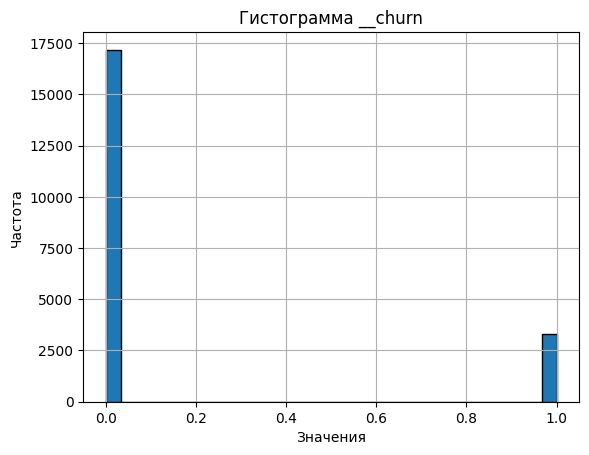

In [36]:
df['__churn'].hist(bins = 30, edgecolor = 'black')
plt.title('Гистограмма __churn')
plt.xlabel('Значения')
plt.ylabel('Частота')
plt.show()

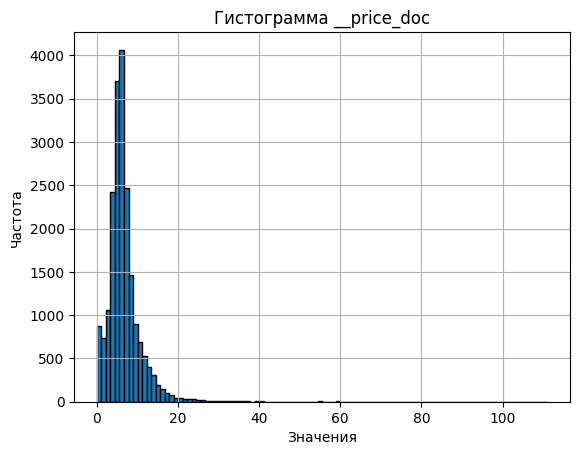

In [37]:
df['__price_doc'].hist(bins = 100, edgecolor = 'black')
plt.title('Гистограмма __price_doc')
plt.xlabel('Значения')
plt.ylabel('Частота')
plt.show()

#### Видим, что __churn не сбалансирован (перекос примерно в 5 раз). Поэтому для её предсказания будем использовать метрику ROC-AUC, так как она не чувствительная к не сбалансированным целевым переменным (также причина в том, что метрика на валидационной выборке тоже ROC-AUC).
#### Для предсказания __price_doc будем использовать NMSLE (Negative Mean Squared Logarithmic Error)

### Посмотрим, сколько NaN у количественных признаков

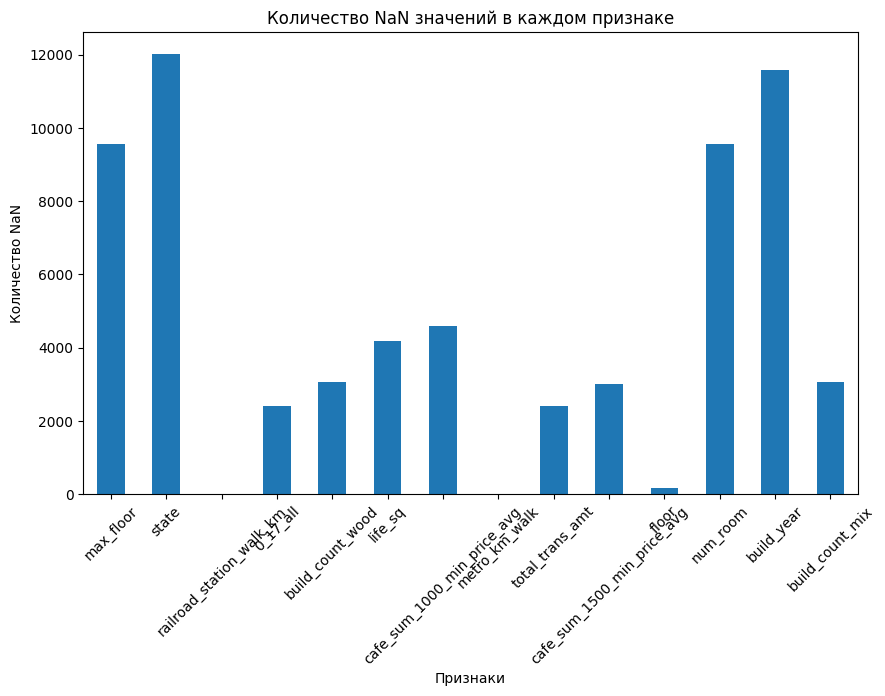

In [38]:
nanCounts = df[numCols].isna().sum()
nanCounts = nanCounts[nanCounts > 0]

plt.figure(figsize = (10, 6))
nanCounts.plot(kind = 'bar')
plt.title('Количество NaN значений в каждом признаке')
plt.xlabel('Признаки')
plt.ylabel('Количество NaN')
plt.xticks(rotation = 45)
plt.show()

#### Заменим их на медиану

In [39]:
df[numCols] = df[numCols].fillna(df[numCols].median())
df[numCols].head()

,max_floor,state,total_revolving_bal,market_count_1500,leisure_count_3000,total_ct_chng_q4_q1,railroad_station_walk_km,contacts_count_12_mon,0_17_all,trc_count_2000,...,cafe_sum_1500_min_price_avg,floor,num_room,months_on_book,dependent_count,avg_open_to_buy,build_year,full_sq,total_relationship_count,build_count_mix
0,12.0,2.0,1906,1,0,0.694,5.419893,2,23603.0,19,...,566.67,4.0,2.0,36,3,1996.9,1978.0,43,5,0.0
1,12.0,2.0,12,0,6,0.693,3.411993,2,17700.0,8,...,694.12,3.0,2.0,29,4,1338.4,1978.0,34,3,0.0
2,12.0,2.0,2153,5,0,0.831,1.277658,2,14884.0,7,...,516.67,2.0,2.0,27,4,2411.5,1978.0,43,6,0.0
3,12.0,2.0,1806,2,0,0.638,4.291432,2,32063.0,7,...,673.91,9.0,2.0,36,2,9255.9,1978.0,89,3,2.0
4,12.0,2.0,753,2,40,0.902,0.853960,2,15237.0,17,...,766.80,4.0,2.0,29,4,3318.2,1978.0,77,4,1.0


In [40]:
df[numCols].isna().sum()

max_floor                                0
state                                    0
total_revolving_bal                      0
market_count_1500                        0
leisure_count_3000                       0
total_ct_chng_q4_q1                      0
railroad_station_walk_km                 0
contacts_count_12_mon                    0
0_17_all                                 0
trc_count_2000                           0
build_count_wood                         0
credit_limit                             0
total_trans_ct                           0
leisure_count_5000                       0
life_sq                                  0
cafe_count_1000_price_1000               0
mkad_km                                  0
school_education_centers_top_20_raion    0
avg_utilization_ratio                    0
public_transport_station_min_walk        0
customer_age                             0
detention_facility_km                    0
sport_count_2000                         0
cafe_sum_10

#### В категориальных признаках нет незаполненных данных, а большинство из них бинарные. У единственный признака timestamp с большим количеством значений оставим только год

In [41]:
df["timestamp"] = df["timestamp"].str.split("-").str[0]

for col in catCols:
    print(f'Значения в "{col}":')
    vc = df[col].value_counts()
    print(vc)
    print()

Значения в "marital_status":
marital_status
Married    11524
Single      8959
Name: count, dtype: int64

Значения в "big_market_raion":
big_market_raion
no     18591
yes     1892
Name: count, dtype: int64

Значения в "water_1line":
water_1line
no     18837
yes     1646
Name: count, dtype: int64

Значения в "culture_objects_top_25":
culture_objects_top_25
no     19367
yes     1116
Name: count, dtype: int64

Значения в "product_type":
product_type
Investment       13440
OwnerOccupier     7043
Name: count, dtype: int64

Значения в "big_road1_1line":
big_road1_1line
no     19940
yes      543
Name: count, dtype: int64

Значения в "card_category":
card_category
Blue      19839
Silver      643
Gold          1
Name: count, dtype: int64

Значения в "income_category":
income_category
Less than $40K    9604
$80K - $120K      4298
$40K - $60K       3141
$60K - $80K       2065
Unknown           1189
$120K +            186
Name: count, dtype: int64

Значения в "thermal_power_plant_raion":
thermal_po

## Анализ данных

### Коррелирующие между собой признаки очень плохо сказываются на обучении модели. Поэтому необходимо убрать их

#### Посчитаем корреляцию признаков

In [ ]:
corrMatrix = df.corr()
threshold = 0.7
#print(corrMatrix)

highCorr = []
for i in range(len(corrMatrix.columns)):
    for j in range(i):
        if abs(corrMatrix.iloc[i, j]) > threshold:
            highCorr.append((corrMatrix.columns[i], corrMatrix.columns[j], corrMatrix.iloc[i, j]))

highCorr = pd.DataFrame(highCorr, columns = ['Признак 1', 'Признак 2', 'Корреляция'])
print(highCorr['Признак 1'].values)